In [1]:
import tensorflow as tf
from keras.optimizer_v1 import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [3]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [4]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [5]:
BATCH_SIZE = 32

EPOCHS = 100

In [6]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = 'C:\\Users\\Ali\Documents\\minipigs_cropped_images\\Split_Data\\train'

# path to VALIDATE dataset of the OCT images
VALID_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_cropped_images\\Split_Data\\val'

# path to TESTING dataset of the OCT images
TEST_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_cropped_images\\Split_Data\\test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [7]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-8]:
    layer.trainable = False

In [8]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [9]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.25)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [13]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 229 images belonging to 5 classes.


In [14]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [15]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 60 images belonging to 5 classes.


In [16]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 35 images belonging to 5 classes.


In [17]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

Epoch 1/100
8/8 [==============================] - 88s 9s/step - loss: 2.7385 - accuracy: 0.2402 - val_loss: 2.7005 - val_accuracy: 0.3500
Epoch 2/100
8/8 [==============================] - 63s 8s/step - loss: 2.4480 - accuracy: 0.2664 - val_loss: 2.2171 - val_accuracy: 0.3000
Epoch 3/100
8/8 [==============================] - 72s 8s/step - loss: 2.2893 - accuracy: 0.2969 - val_loss: 2.6868 - val_accuracy: 0.2167
Epoch 4/100
8/8 [==============================] - 52s 6s/step - loss: 2.0785 - accuracy: 0.3581 - val_loss: 1.9981 - val_accuracy: 0.3833
Epoch 5/100
8/8 [==============================] - 62s 8s/step - loss: 2.0361 - accuracy: 0.3755 - val_loss: 1.7978 - val_accuracy: 0.3667
Epoch 6/100
8/8 [==============================] - 44s 5s/step - loss: 1.7867 - accuracy: 0.4279 - val_loss: 1.8076 - val_accuracy: 0.3667
Epoch 7/100
8/8 [==============================] - 68s 8s/step - loss: 1.7718 - accuracy: 0.4585 - val_loss: 1.7293 - val_accuracy: 0.5167
Epoch 8/100
8/8 [==========

8/8 [==============================] - 22s 3s/step - loss: 0.7928 - accuracy: 0.7031 - val_loss: 1.2617 - val_accuracy: 0.5333
Epoch 60/100
8/8 [==============================] - 29s 4s/step - loss: 0.7995 - accuracy: 0.7118 - val_loss: 0.8218 - val_accuracy: 0.6500
Epoch 61/100
8/8 [==============================] - 34s 5s/step - loss: 0.8258 - accuracy: 0.7249 - val_loss: 0.9869 - val_accuracy: 0.6667
Epoch 62/100
8/8 [==============================] - 31s 4s/step - loss: 0.7545 - accuracy: 0.7074 - val_loss: 0.7186 - val_accuracy: 0.7333
Epoch 63/100
8/8 [==============================] - 28s 3s/step - loss: 0.8396 - accuracy: 0.6725 - val_loss: 0.7718 - val_accuracy: 0.6500
Epoch 64/100
8/8 [==============================] - 26s 3s/step - loss: 0.8078 - accuracy: 0.7074 - val_loss: 0.8989 - val_accuracy: 0.6833
Epoch 65/100
8/8 [==============================] - 20s 2s/step - loss: 0.8881 - accuracy: 0.7118 - val_loss: 0.7859 - val_accuracy: 0.6500
Epoch 66/100
8/8 [===============

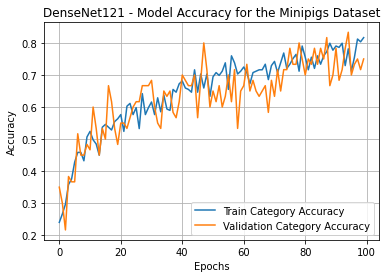

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

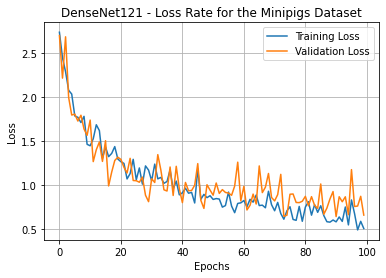

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [20]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 4s 85ms/step - loss: 0.9620 - accuracy: 0.7000

Learn Rate = 0.0001 , Epochs = 100 , Training Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\train
Validation Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\val , Test Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\test

Training: 0.852, Validation: 0.700

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [21]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 [==============================] - 2s 19ms/step - loss: 1.1371 - accuracy: 0.6571

Test loss and accuracy are: [1.1370714902877808, 0.6571428775787354]
